# VQE_Scratch 
## The optimizer will be replaced later maybe after I study more about QML because I suspect I will need it there too.

This is support for: [VQE_Scretch](https://www.notion.so/VQE_Scratch-7d6ca0f3f44c4430a8e6202f7de779db)
where I try to naively explain what I understood ( there are also presented: decompose, expected from tools). For math and clarity, I recommend reading the references. 
I really insist that it would be better to read the references before or after if you are interested.

In [1]:
import  numpy as np 

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister 
from qiskit import Aer, execute
from qiskit.aqua.algorithms import NumPyEigensolver

In [2]:
# I put decompose and expected in tools to make the  notebook more readable.
# But here are some key elements so I advice you to study them either there or in the references: ([4]), ([1][3]);
# or on the page that accompanies this notebook: https://www.notion.so/VQE_Scratch-7d6ca0f3f44c4430a8e6202f7de779db

from tools import decompose, expected

In [3]:
# For the moment I will use scipy but i intend to create one in future. So is not so it's not really scratch.

from scipy.optimize import minimize

In [4]:
# Because I just want to show myself that it works, I will only use the simulator. 
# For more advanced experiments I will use what Qiskit already offers.

backend=Aer.get_backend('qasm_simulator')

In [5]:
# I will choose an operator with the result already known so that I can check myself.
# Amazing resources: https://github.com/Cryoris/notebooks/blob/master/Circuit%20library%20%26%20native%20circuits.ipynb

I=np.array([[1,0],[0,1]],dtype=np.complex128)
X=np.array([[0,1],[1,0]],dtype=np.complex128)
Y=np.array([[0,-1.0j],[1.0j,0]],dtype=np.complex128)
Z=np.array([[1,0],[0,-1]],dtype=np.complex128)

H=-1.05 * np.kron(I,I) + 0.39 * np.kron(I,Z) - 0.39 * np.kron(Z,I) - 0.01 * np.kron(Z,Z) + 0.18 * np.kron(X,X)
ref=-1.85727503 
print(H)

[[-1.06+0.j  0.  +0.j  0.  +0.j  0.18+0.j]
 [ 0.  +0.j -1.82+0.j  0.18+0.j  0.  +0.j]
 [ 0.  +0.j  0.18+0.j -0.26+0.j  0.  +0.j]
 [ 0.18+0.j  0.  +0.j  0.  +0.j -1.06+0.j]]


In [6]:
# Now we know how H shoul look like but usualy we  need to decompoe him in sum of paui product and these decomposition depend of the mapping.

h,h_label=decompose(H)
for i in range(len(h_label)):
    if(h[i]!=0):
        print(h_label[i])
        print(h[i])

II
(-1.0499999999999998+0j)
IZ
(0.38999999999999996+0j)
XX
(0.18+0j)
ZI
(-0.39+0j)
ZZ
(-0.009999999999999953+0j)


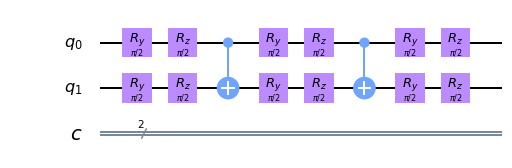

In [7]:
# Ansatz RZRY -> these is just an example of ansatz 
# Look at ref [2]

def ryrz(H,parm,depth):
    
    nrq=int(np.log2(len(H)))
    ansatz=QuantumCircuit(nrq,nrq)
    it=iter(parm)
    
        
    for i in range(nrq):
        
        ansatz.ry(next(it),i)
        ansatz.rz(next(it),i)
            
            
    for g in range(depth):
        
        for l in range(nrq-1):
            ansatz.cx(l,l+1)
            
        for i in range(nrq):
            ansatz.ry(next(it),i)
            ansatz.rz(next(it),i)
          
        
            
    return ansatz

depth=2
pi=np.pi
parm=np.array([pi/2, pi/2, pi/2,pi/2,  pi/2, pi/2, pi/2,pi/2,pi/2, pi/2, pi/2,pi/2,pi/2, pi/2, pi/2,pi/2])
ansatz=ryrz(H,parm,depth=depth)
ansatz.draw('mpl')

In [8]:
# Caluclate final expected value as sum of h[i]<psi|h_obs|psi> where h_obs-> h_label[i].

def value(h,h_label,ansatz,backend):
    
    val=0
    for i in range(len(h)):
        if h[i]!=0:
            exp=expected(ansatz,h_label[i],shots=100000,backend=backend)
            val=val+h[i]*exp
            #print('exp for {} ={}'.format(h_label[i],exp))
            
    return (val)

print(value(h,h_label,ansatz,backend))

(-1.2299491999999999+0j)


In [9]:
# I think this could be incorporated into VQE and pass the value to the optimizer but it's nicer to have a Cost function. 

def cost(parm,H,depth,backend):
    
    h,h_label=decompose(H)
    ansatz=ryrz(H,parm,depth)
   
    return value(h,h_label,ansatz,backend)

In [10]:
# Combine everything.

def VQE(H,depth,backend):
    
    nrq=int(np.log2(len(H)))
    parm=np.full(4*nrq+4*depth,np.pi/2 )
    
    optim=minimize(cost, parm,args=(H,depth,backend),method='COBYLA', options={'rhobeg': 1.0, 'maxiter': 2000, 'disp': True, 'catol': 0.0002})
    
    ansatz=ryrz(H,optim.x,depth)
    eigval=value(h,h_label,ansatz,backend)
    
    return eigval

In [ ]:
#Result.

print("Result: ",VQE(H,depth=2,backend=backend))
print("Reference:",ref)

C:\Users\tomut\Anaconda3\envs\venvQ\lib\site-packages\scipy\optimize\cobyla.py:262: ComplexWarning: Casting complex values to real discards the imaginary part
  dinfo=info)


## Resources

<ul>
    <li>[1] Qiskit QGSC lab 9 : https://youtu.be/Rs2TzarBX5I </li>
    <li>[2] Hardware-efficient Variational Quantum Eigensolver for Small Molecules and
Quantum Magnets : 	arXiv:1704.05018 
</li>
    <li>[3] General expectation value: https://quantumcomputing.stackexchange.com/questions/11408/qiskit-z-expectation-value-from-counts</li>
    <li>[4] Decomposing Two-Qubit Hamiltonians into Pauli-Matrices. Michael Gores: https://michaelgoerz.net/notes/decomposing-two-qubit-hamiltonians-into-pauli-matrices.html</li>
</ul>

In [12]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright